# Import everything

In [116]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import math
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz
from itertools import combinations
import openpyxl
from scipy.stats import pearsonr
from matplotlib import colors as mcolors

# Read powers and phases

In [147]:
df_power = pd.read_csv('157-d2-power-v2.csv')
df_phase = pd.read_csv('157-d2-phase-v2.csv')

In [148]:
# Fix some columns and values for readability.
df_power.loc[df_power['EEG'] == 'Average', 'EEG'] = "M1 Average"
df_power.loc[df_power['Time'] == -150, 'Time'] = "-150ms"
df_power.loc[df_power['Time'] == -750, 'Time'] = "-750ms"
df_phase.loc[df_phase['EEG'] == 'Averaged', 'EEG'] = "M1 Average"
df_power = df_power.rename(columns={'ArtifactRemoved': 'Artifact Removed'})
df_phase = df_phase.rename(columns={'ArtifactRemoved': 'Artifact Removed'})
for col in ['Artifact Removed']:
    df_power.loc[df_power[col] == True, col] = "Yes"
    df_power.loc[df_power[col] == False, col] = "No"
    df_phase.loc[df_phase[col] == True, col] = "Yes"
    df_phase.loc[df_phase[col] == False, col] = "No"

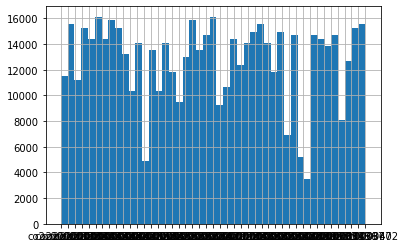

In [133]:
df_power['sub'].hist(bins=df_power['sub'].nunique())

# Default values

In [134]:
# Dataset 2
def_values_power = {
    'Artifact Removed': 'No',
    'EEG': 'Raw', 
    'Filter': 'Butterworth', 
    'Time': '-750ms', 
    'Method': 'Welch'
}
hue_order_power = {
    'Artifact Removed': ['Yes', 'No'],
    'EEG': ['Raw', 'Hjorth', 'M1 Average'], 
    'Filter': ['Blackmann-Harris', 'Butterworth'], 
    'Time': ['-150ms', '-750ms'], 
    'Method': ['FFT', 'Welch', 'Burg']
}
def_values_phase = {
    'Artifact Removed': 'Yes',
    'EEG': 'Raw',
    'Filter': 'Butterworth', 
}

# PSDs across trial

--------------
Artifact Removed
--------------
Performing EEG = Raw for constant Artifact Removed, shape = (1104, 13)
Performing Filter = Butterworth for constant Artifact Removed, shape = (552, 13)
Performing Time = -750ms for constant Artifact Removed, shape = (276, 13)
Performing Method = Welch for constant Artifact Removed, shape = (92, 13)
--------------
EEG
--------------
Performing Artifact Removed = No for constant EEG, shape = (1656, 13)
Performing Filter = Butterworth for constant EEG, shape = (828, 13)
Performing Time = -750ms for constant EEG, shape = (414, 13)
Performing Method = Welch for constant EEG, shape = (138, 13)
--------------
Filter
--------------
Performing Artifact Removed = No for constant Filter, shape = (1656, 13)
Performing EEG = Raw for constant Filter, shape = (552, 13)
Performing Time = -750ms for constant Filter, shape = (276, 13)
Performing Method = Welch for constant Filter, shape = (92, 13)
--------------
Time
--------------
Performing Artifact Remov

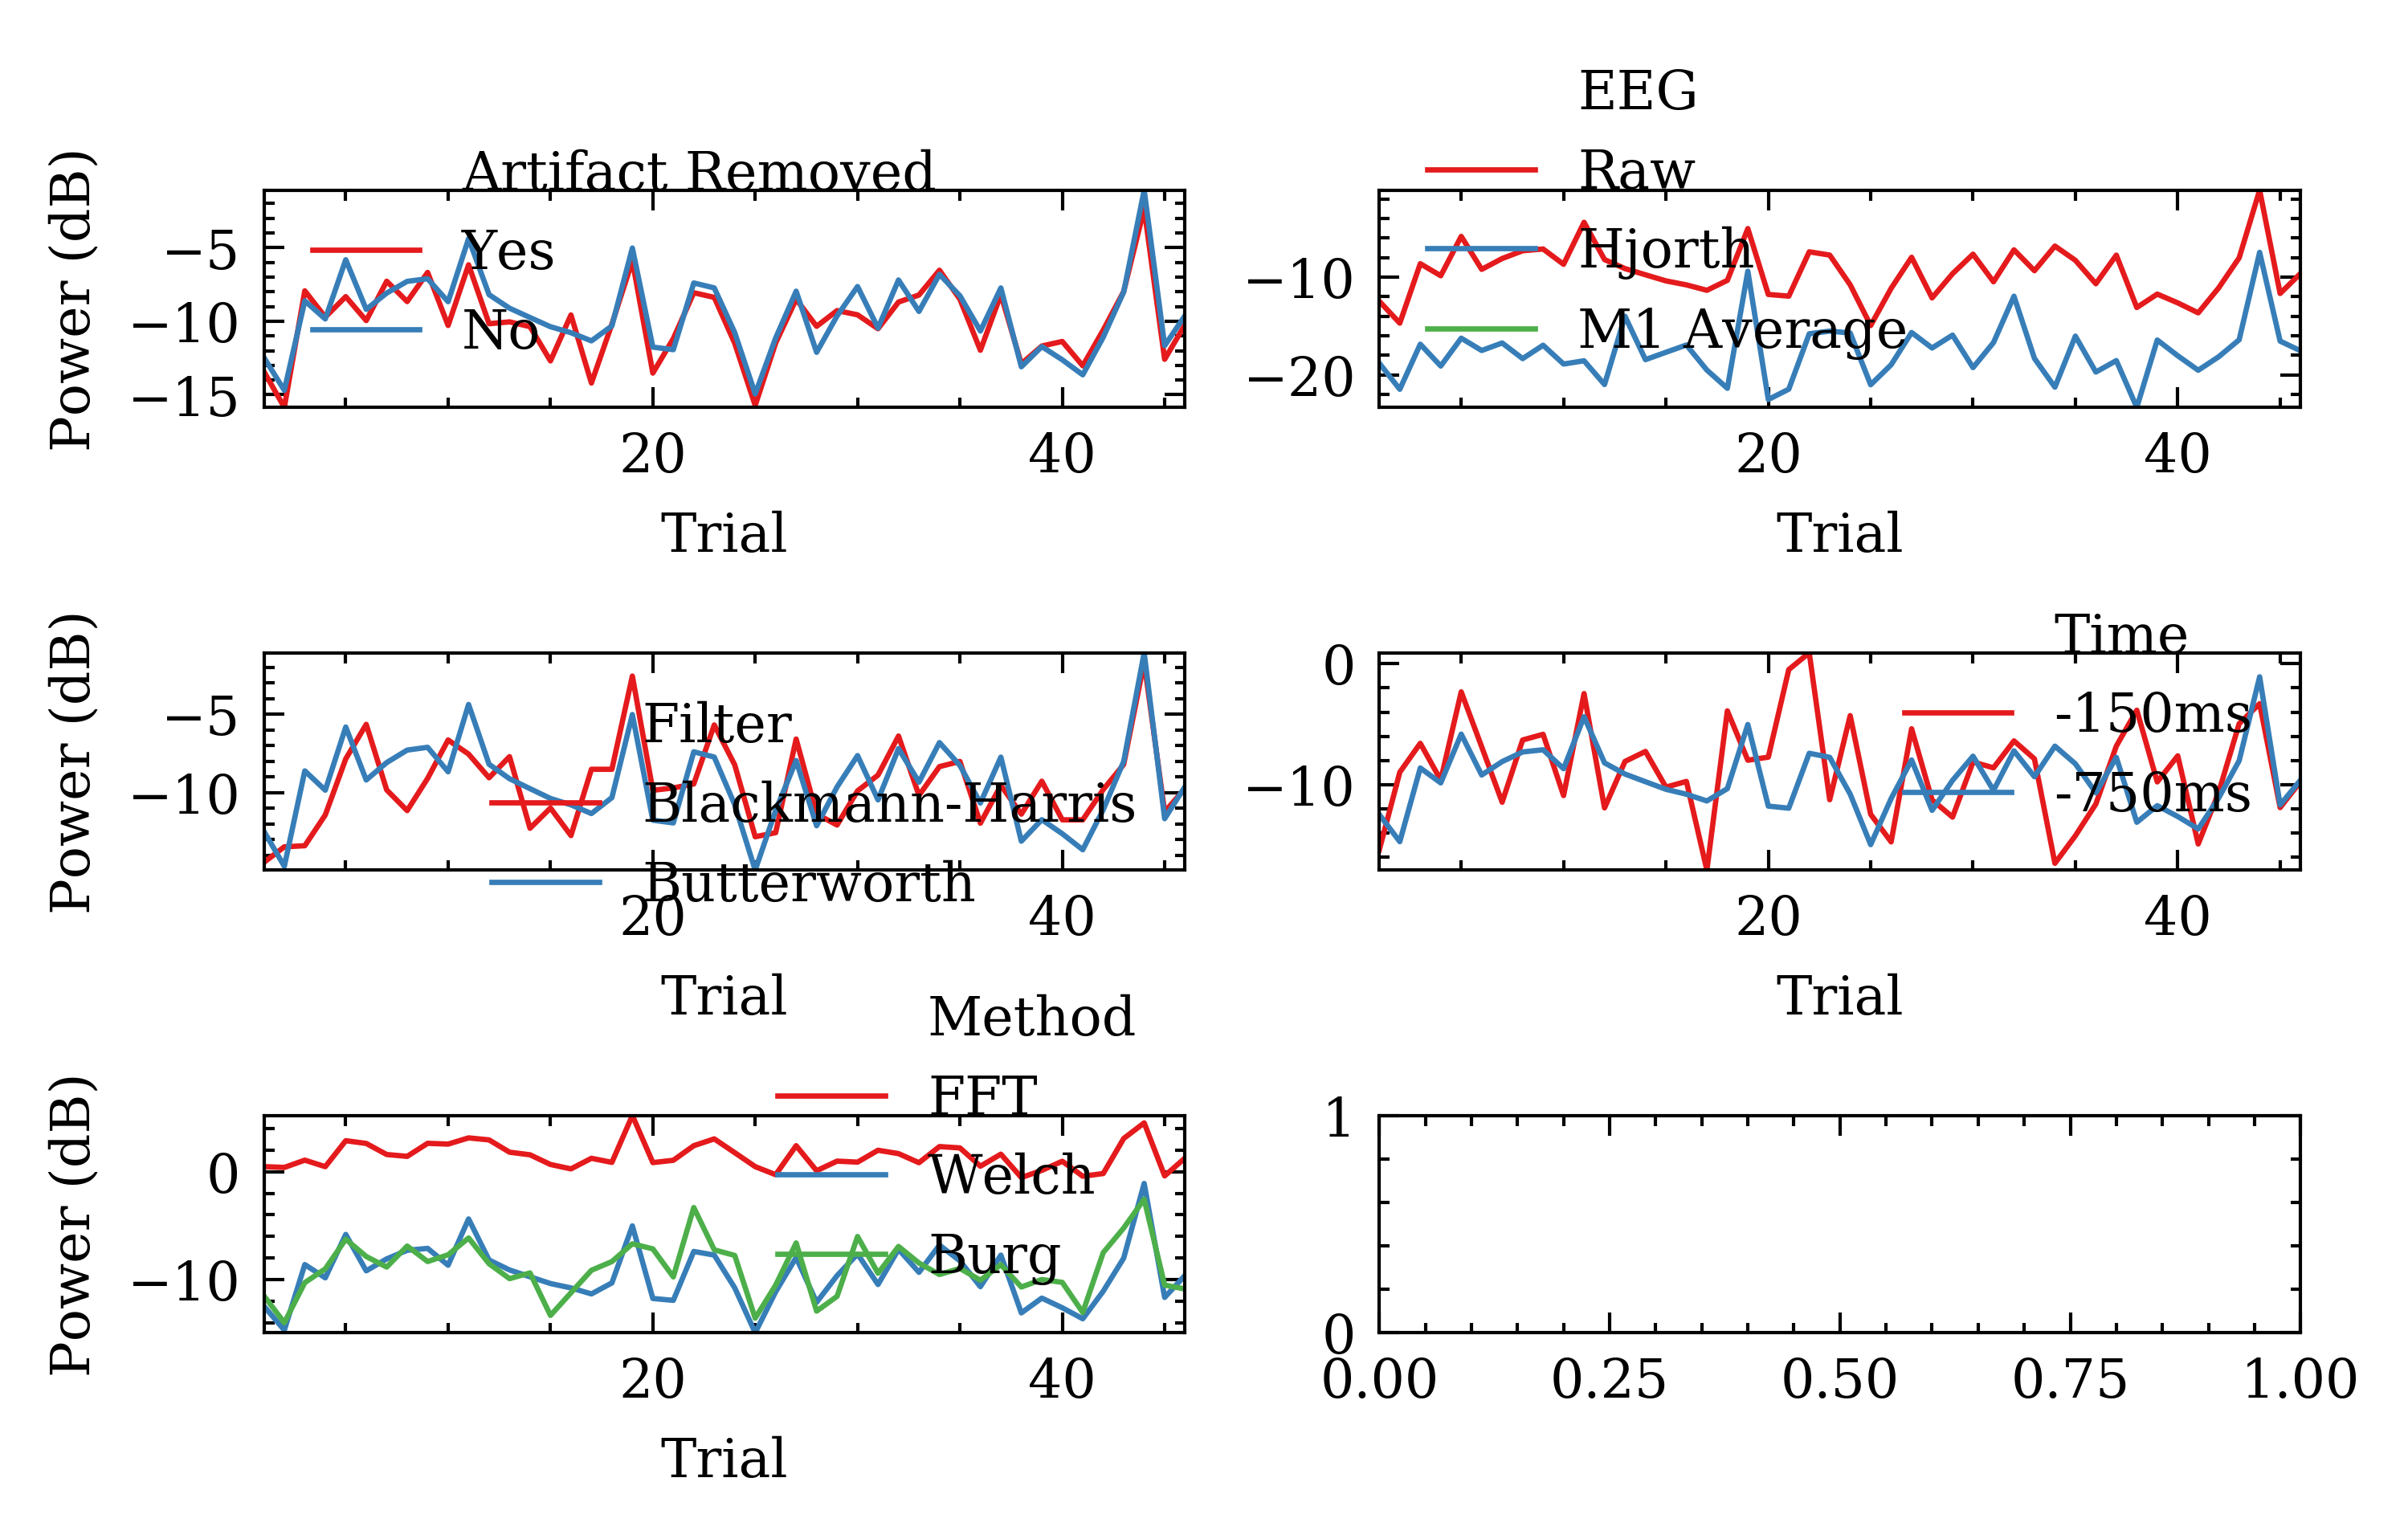

In [135]:
df_power2 = df_power[df_power['sub'] == df_power['sub'].unique()[9]]
df_power2 = df_power2[df_power2['Band'] == 'Beta']
with plt.style.context(['science-raquib2']):
    f, axs = plt.subplots(3, 2, figsize=(5,3))
    # f, axs = plt.subplots(2,3,figsize=(13, 8))
    i = 0
    j = 0
    for variable in tqdm(list(def_values_power.keys())):
        df_power3 = df_power2
        print('--------------')
        print(variable)
        print('--------------')
        for key, value in def_values_power.items():
            if key != variable:
                df_power3 = df_power3[df_power3[key] == value]
                print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

        df_power3 = df_power3[['trial_abs', 'Power', variable]]
        sns.lineplot(x="trial_abs", y="Power", hue=variable, data=df_power3, ax=axs[i, j], hue_order=hue_order_power[variable], palette=sns.color_palette("Set1", df_power3[variable].nunique()))
        # axs[i, j].set_ylim([-25,35])
        # plt.setp(axs[i, j].lines, color='k')
        # axs[i, j].get_legend().remove()
        axs[i,j].set_xlabel('Trial')
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')
        else:
            axs[i, j].set_ylabel('')
#             axs[i, j].get_yaxis().set_ticks([])
        j = j + 1
        if j > 1:
            j = 0
            i = i + 1

    plt.tight_layout()

# Box plots - PSD

--------------
Artifact Removed
--------------
Performing EEG = Raw for constant Artifact Removed, shape = (3456, 13)
Performing Filter = Butterworth for constant Artifact Removed, shape = (1728, 13)
Performing Time = -750ms for constant Artifact Removed, shape = (864, 13)
Performing Method = Welch for constant Artifact Removed, shape = (288, 13)
--------------
EEG
--------------
Performing Artifact Removed = No for constant EEG, shape = (5184, 13)
Performing Filter = Butterworth for constant EEG, shape = (2592, 13)
Performing Time = -750ms for constant EEG, shape = (1296, 13)
Performing Method = Welch for constant EEG, shape = (432, 13)
--------------
Filter
--------------
Performing Artifact Removed = No for constant Filter, shape = (5184, 13)
Performing EEG = Raw for constant Filter, shape = (1728, 13)
Performing Time = -750ms for constant Filter, shape = (864, 13)
Performing Method = Welch for constant Filter, shape = (288, 13)
--------------
Time
--------------
Performing Artifact

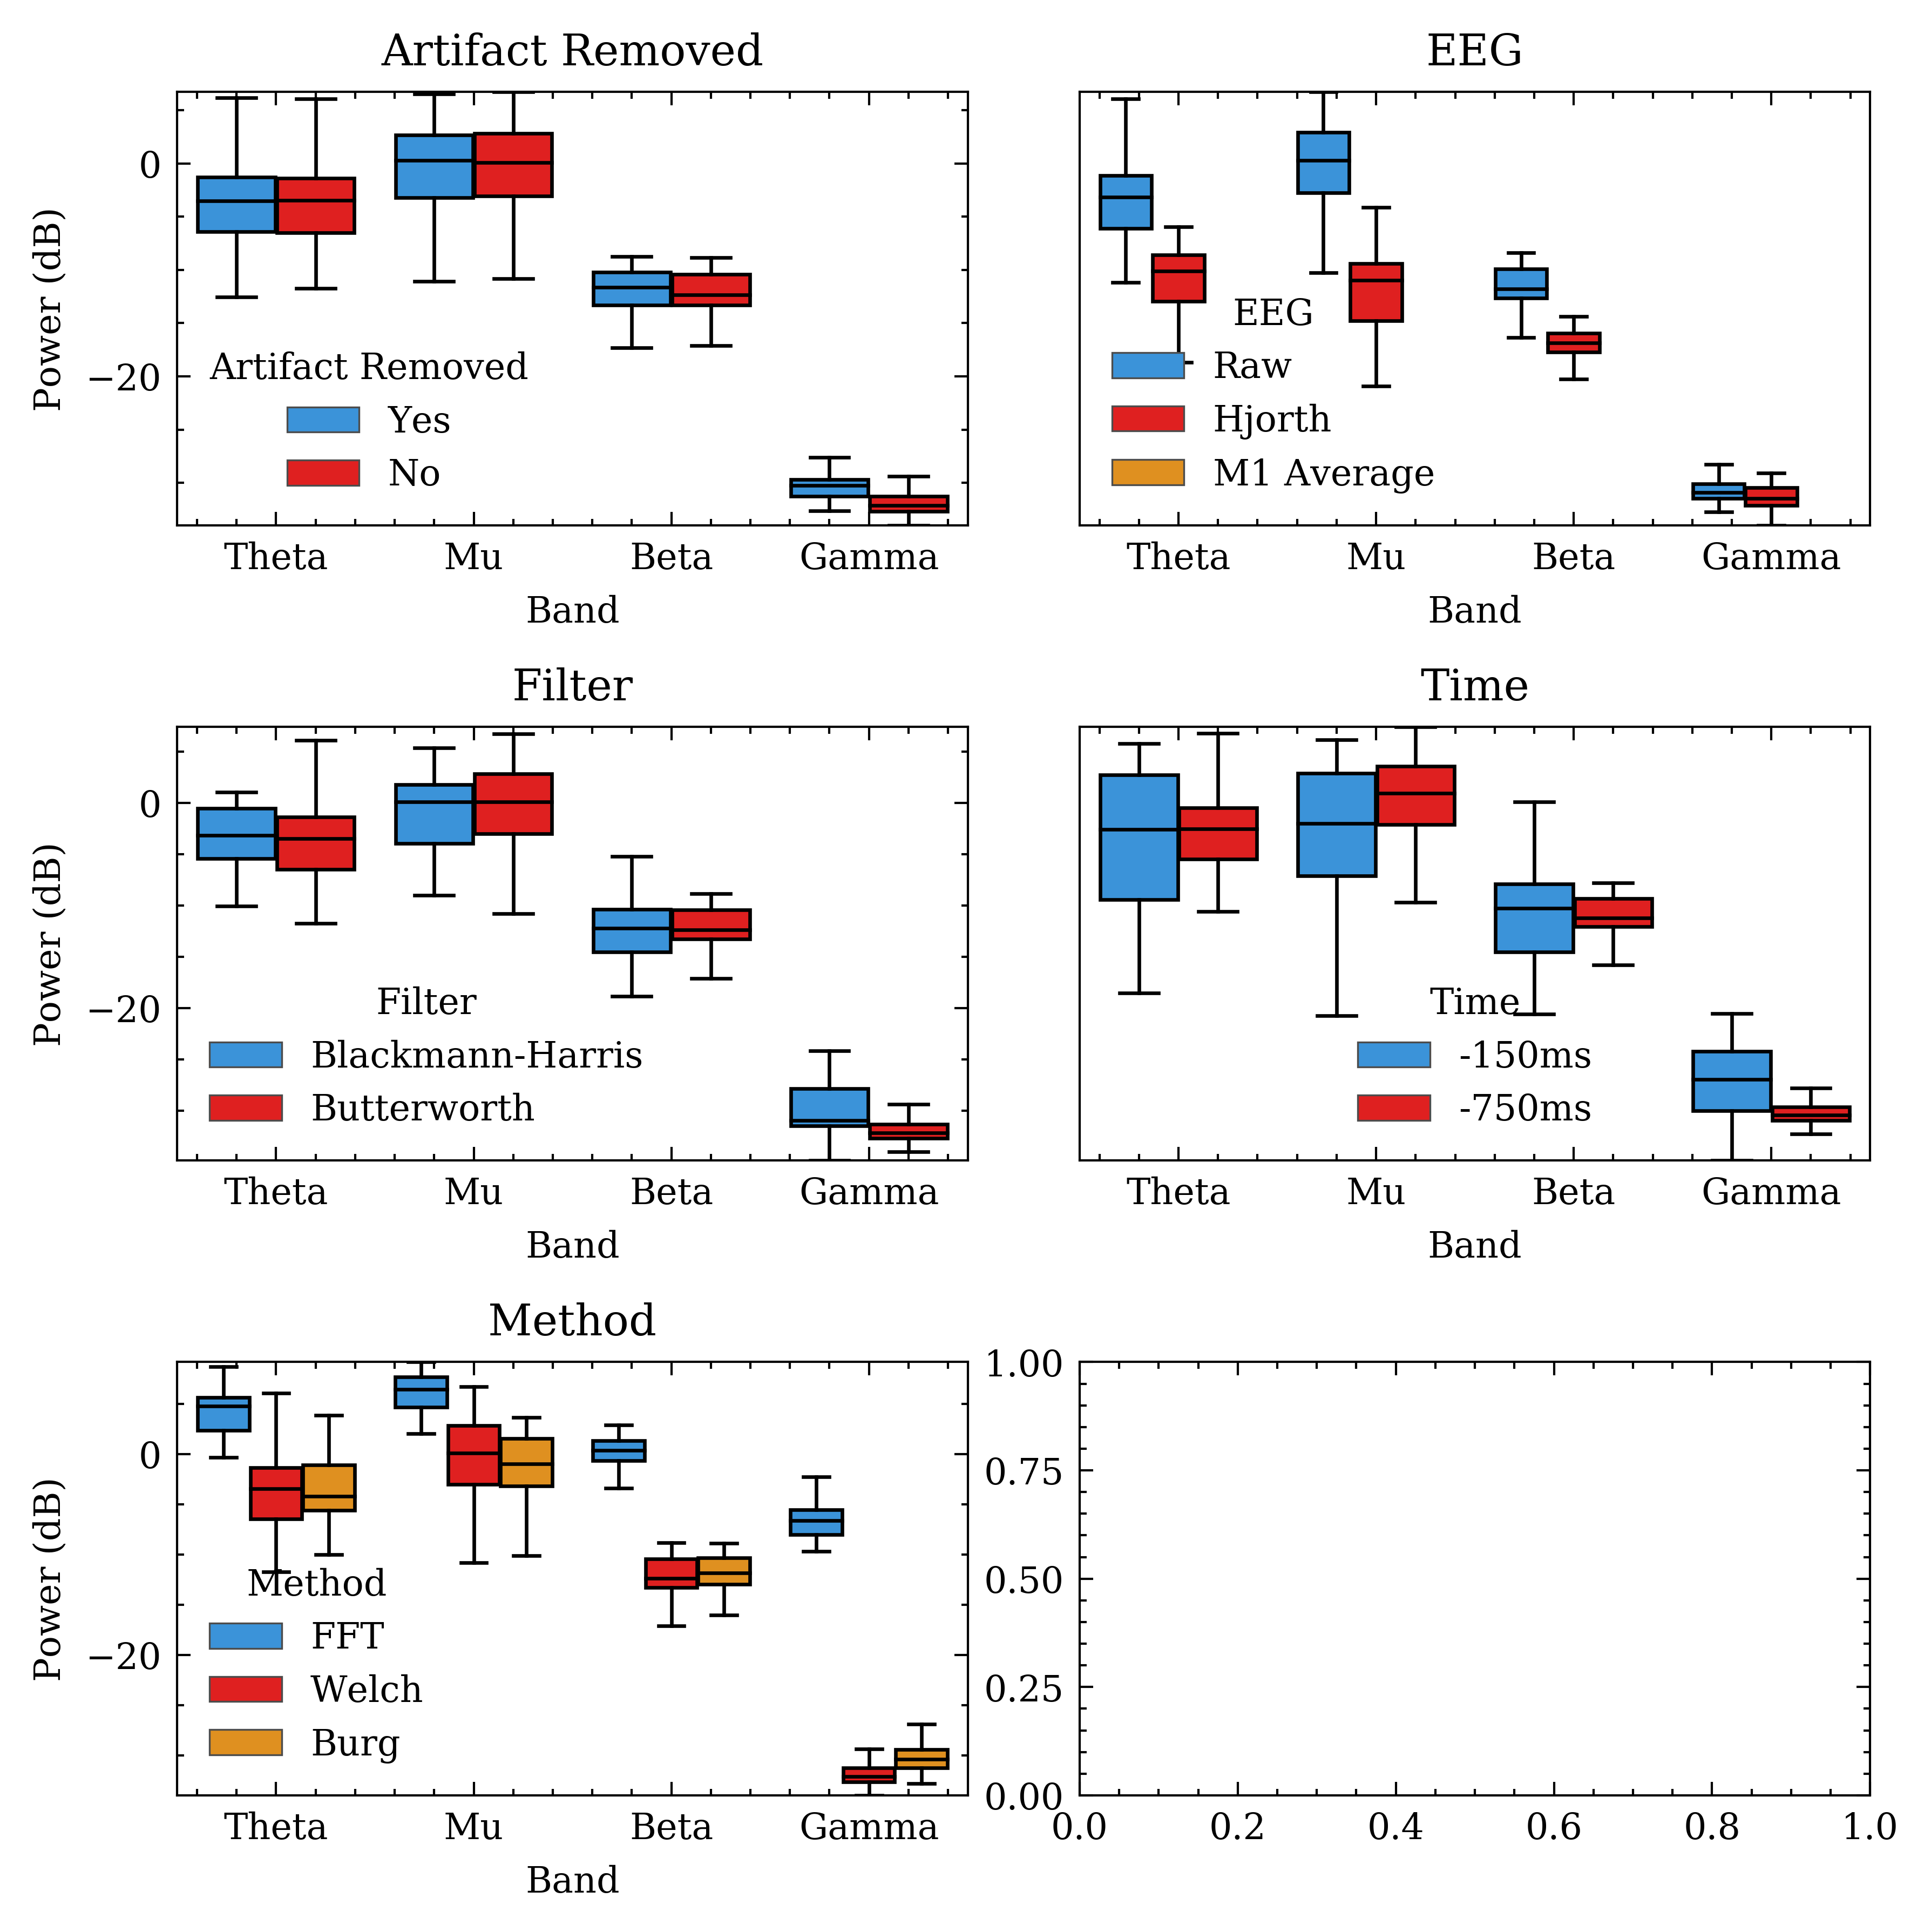

In [137]:
df_power2 = df_power[df_power['sub'] == df_power['sub'].unique()[10]]
with plt.style.context(['science-raquib2']):
    f, axs = plt.subplots(3,2,figsize=(6, 6))
    # f, axs = plt.subplots(2,3,figsize=(13, 8))
    i = 0
    j = 0
    for variable in tqdm(list(def_values_power.keys())):    
        df_power3 = df_power2
        print('--------------')
        print(variable)
        print('--------------')
        for key, value in def_values_power.items():
            if key != variable:
                df_power3 = df_power3[df_power3[key] == value]
                print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

        g = sns.boxplot(x="Band", y="Power", hue=variable, data=df_power3, ax=axs[i, j], fliersize=0, hue_order=hue_order_power[variable])
        # axs[i, j].set_ylim([-25,30])
        plt.setp(axs[i, j].lines, color='k')
        axs[i, j].set_title(variable)
        # axs[i, j].get_legend().remove()
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')
        else:
            axs[i, j].set_ylabel('')
            axs[i, j].get_yaxis().set_ticks([])
        j = j + 1
        if j > 1:
            j = 0
            i = i + 1
        
        for _, box in enumerate(g.artists):
            box.set_edgecolor('black')
    plt.tight_layout()

# Interaction plot - PSD

Plotting in (0, 0): ('Artifact Removed', 'EEG'), shape: (216, 13), unique1: ['No' 'Yes'], unique2: ['Raw' 'Hjorth' 'Average']



ValueError: 'c' argument has 2 elements, which is not acceptable for use with 'x' with size 0, 'y' with size 0.

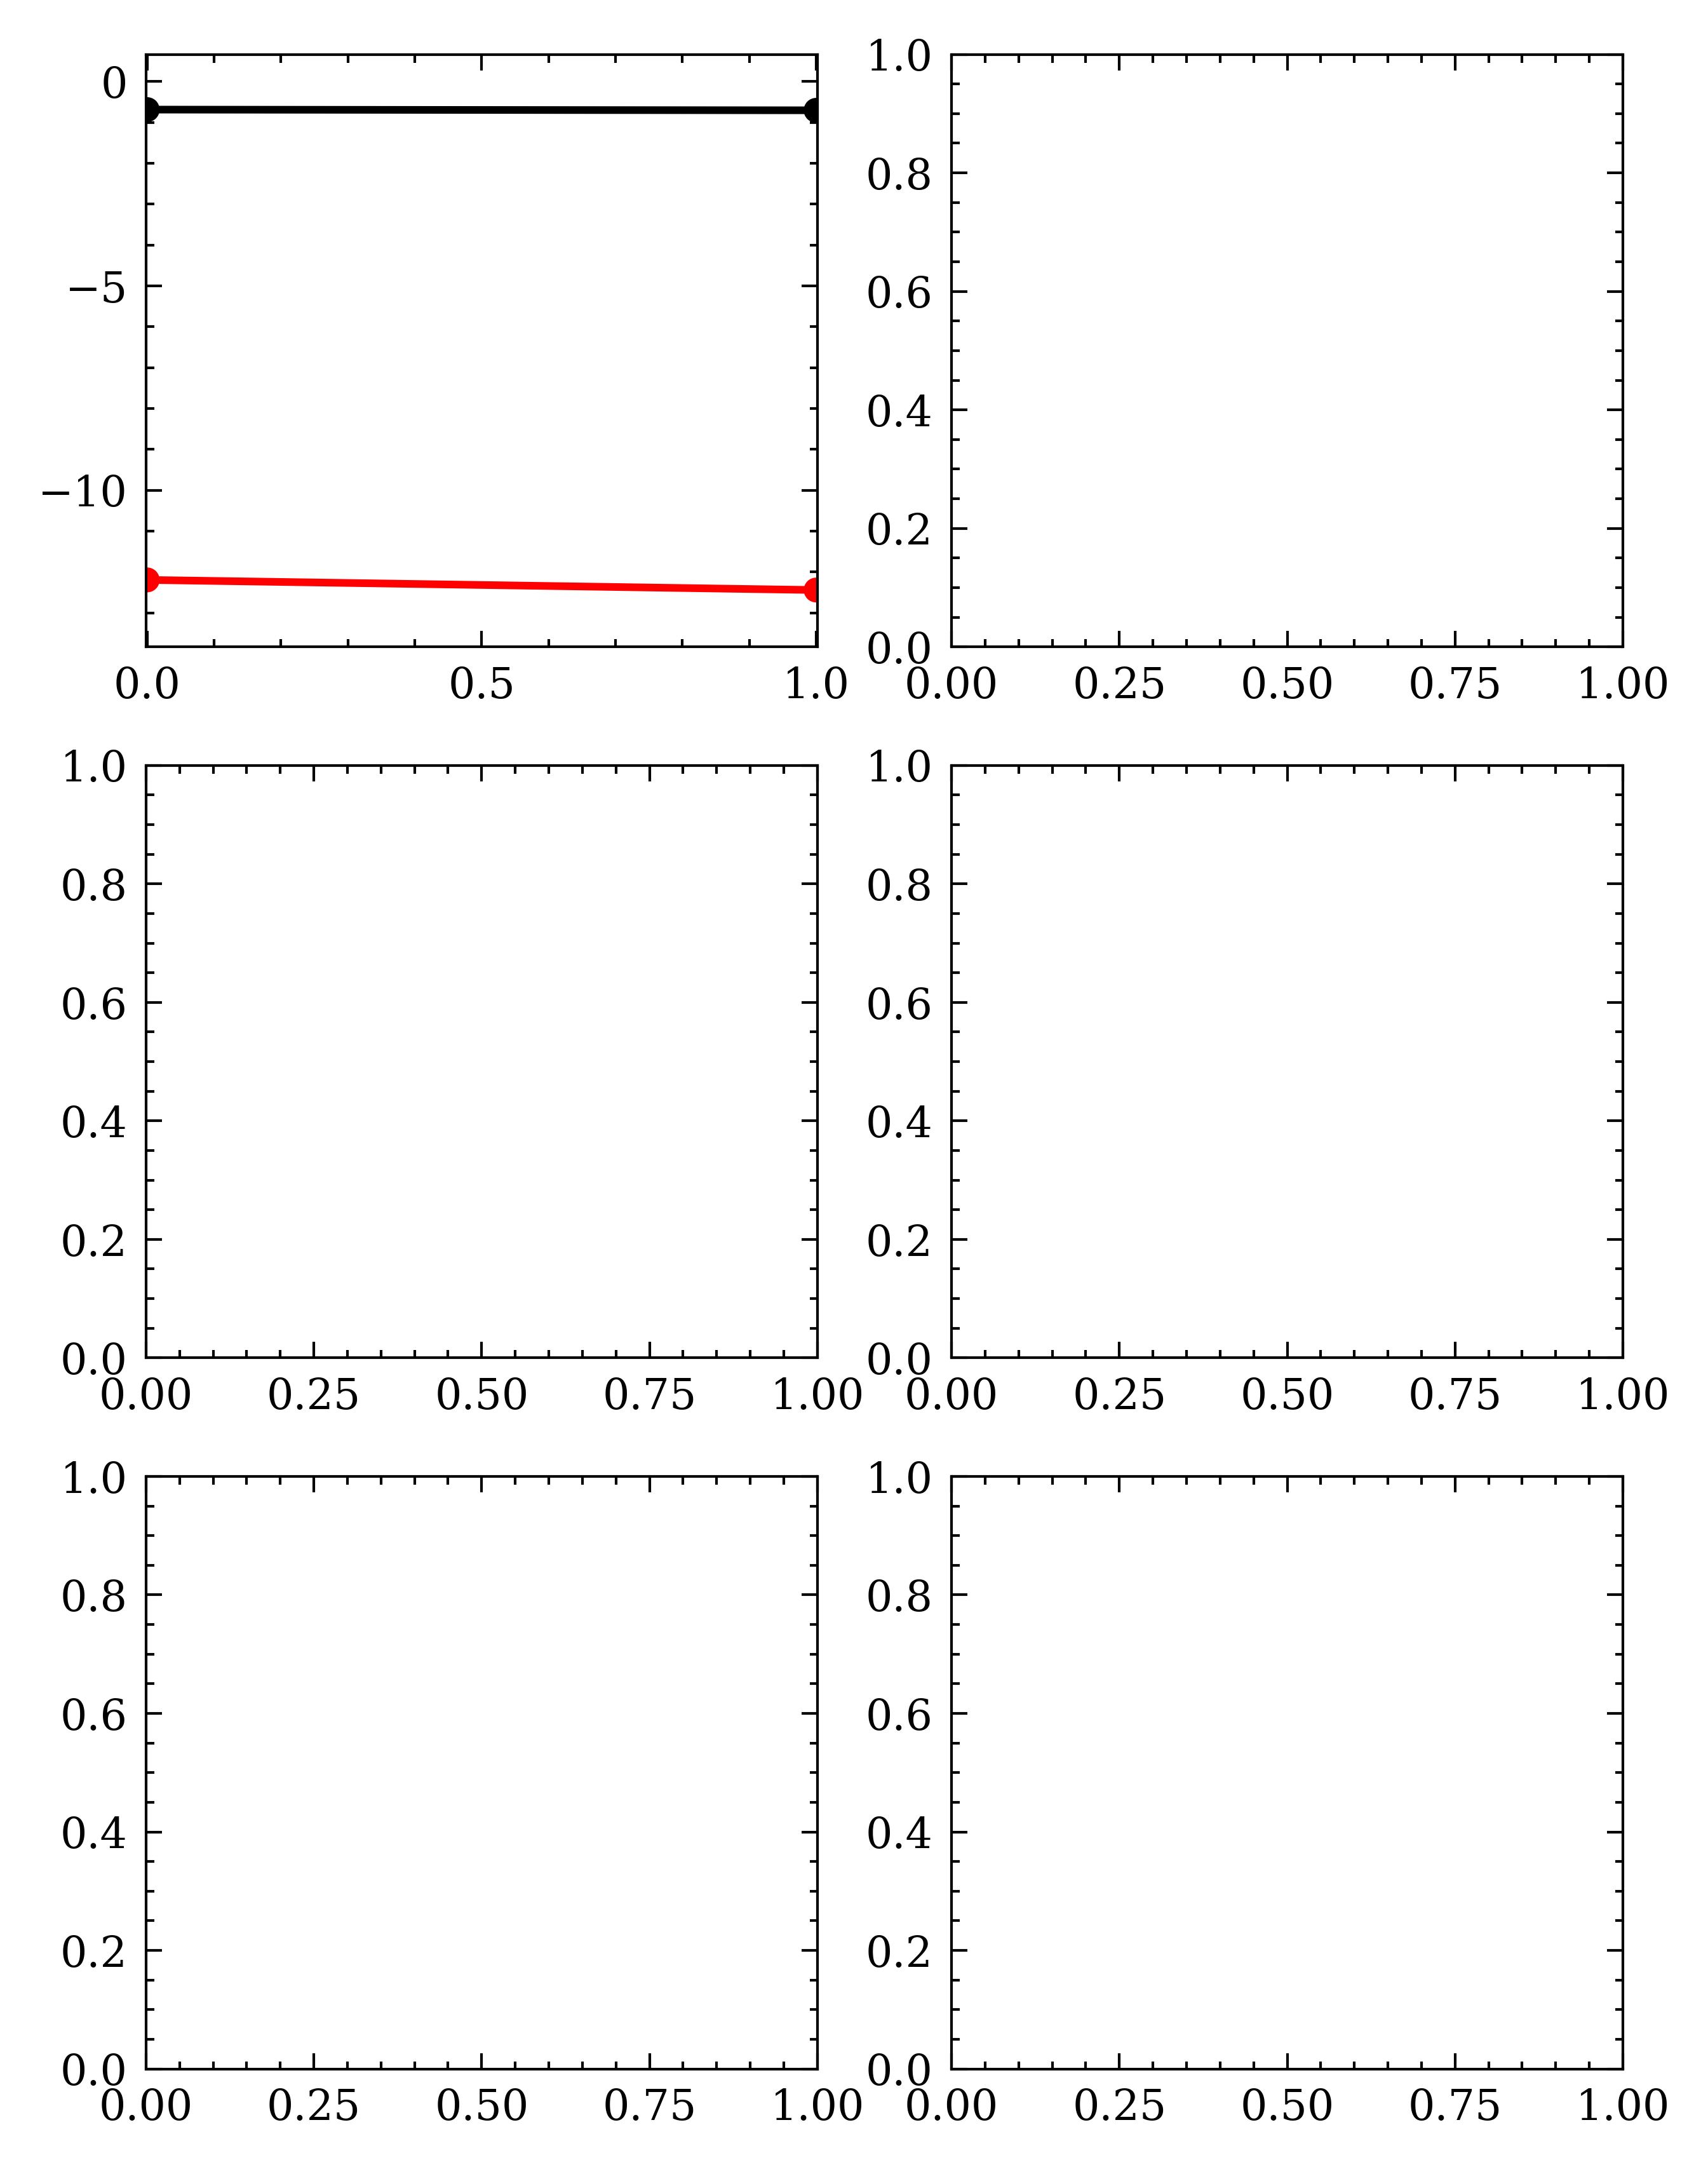

In [139]:
combs = list(combinations(list(def_values_power.keys()), 2))
df_power2 = df_power[df_power['Band'] == 'Mu']
df_power2 = df_power2[df_power2['sub'] == df_power2['sub'].unique()[10]]
i = 0
j = 0
with plt.style.context(['science-raquib']):
    f, axs = plt.subplots(3,2,figsize=(5,7))
    for comb in tqdm(combs):
        df_power3 = df_power2.copy()
        for key, value in def_values_power.items():
            if key not in comb:
                df_power3 = df_power3[df_power3[key] == value]
        print("Plotting in ({}, {}): {}, shape: {}, unique1: {}, unique2: {}".format(i, j, comb, df_power3.shape, df_power3[comb[0]].unique(), df_power3[comb[1]].unique()))
        df_power3 = df_power3[[comb[0], comb[1], 'Power']]
        sns.pointplot(x=comb[0], y="Power", hue=comb[1], data=df_power3, errwidth=0, ax=axs[i,j], order=hue_order_power[comb[0]], hue_order=hue_order_power[comb[1]])
        # axs[i, j].get_legend().remove()
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')

        else:
            axs[i, j].set_ylabel('')
        axs[i, j].set_xlabel(comb[0])
        # axs[i, j].set_ylim([-12, 32])
        j = j + 1
        if j > 1:
            i = i + 1
            j = 0
    plt.tight_layout()

# Histogram - phases

Artifact Removed, Band: Theta, Options: ['No' 'Yes']
Artifact Removed, Band: Mu, Options: ['No' 'Yes']
Artifact Removed, Band: Beta, Options: ['No' 'Yes']
Artifact Removed, Band: Gamma, Options: ['No' 'Yes']
EEG, Band: Theta, Options: ['Raw' 'Hjorth' 'Average']
EEG, Band: Mu, Options: ['Raw' 'Hjorth' 'Average']
EEG, Band: Beta, Options: ['Raw' 'Hjorth' 'Average']
EEG, Band: Gamma, Options: ['Raw' 'Hjorth' 'Average']
Filter, Band: Theta, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Mu, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Beta, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Gamma, Options: ['Butterworth' 'Blackmann-Harris']



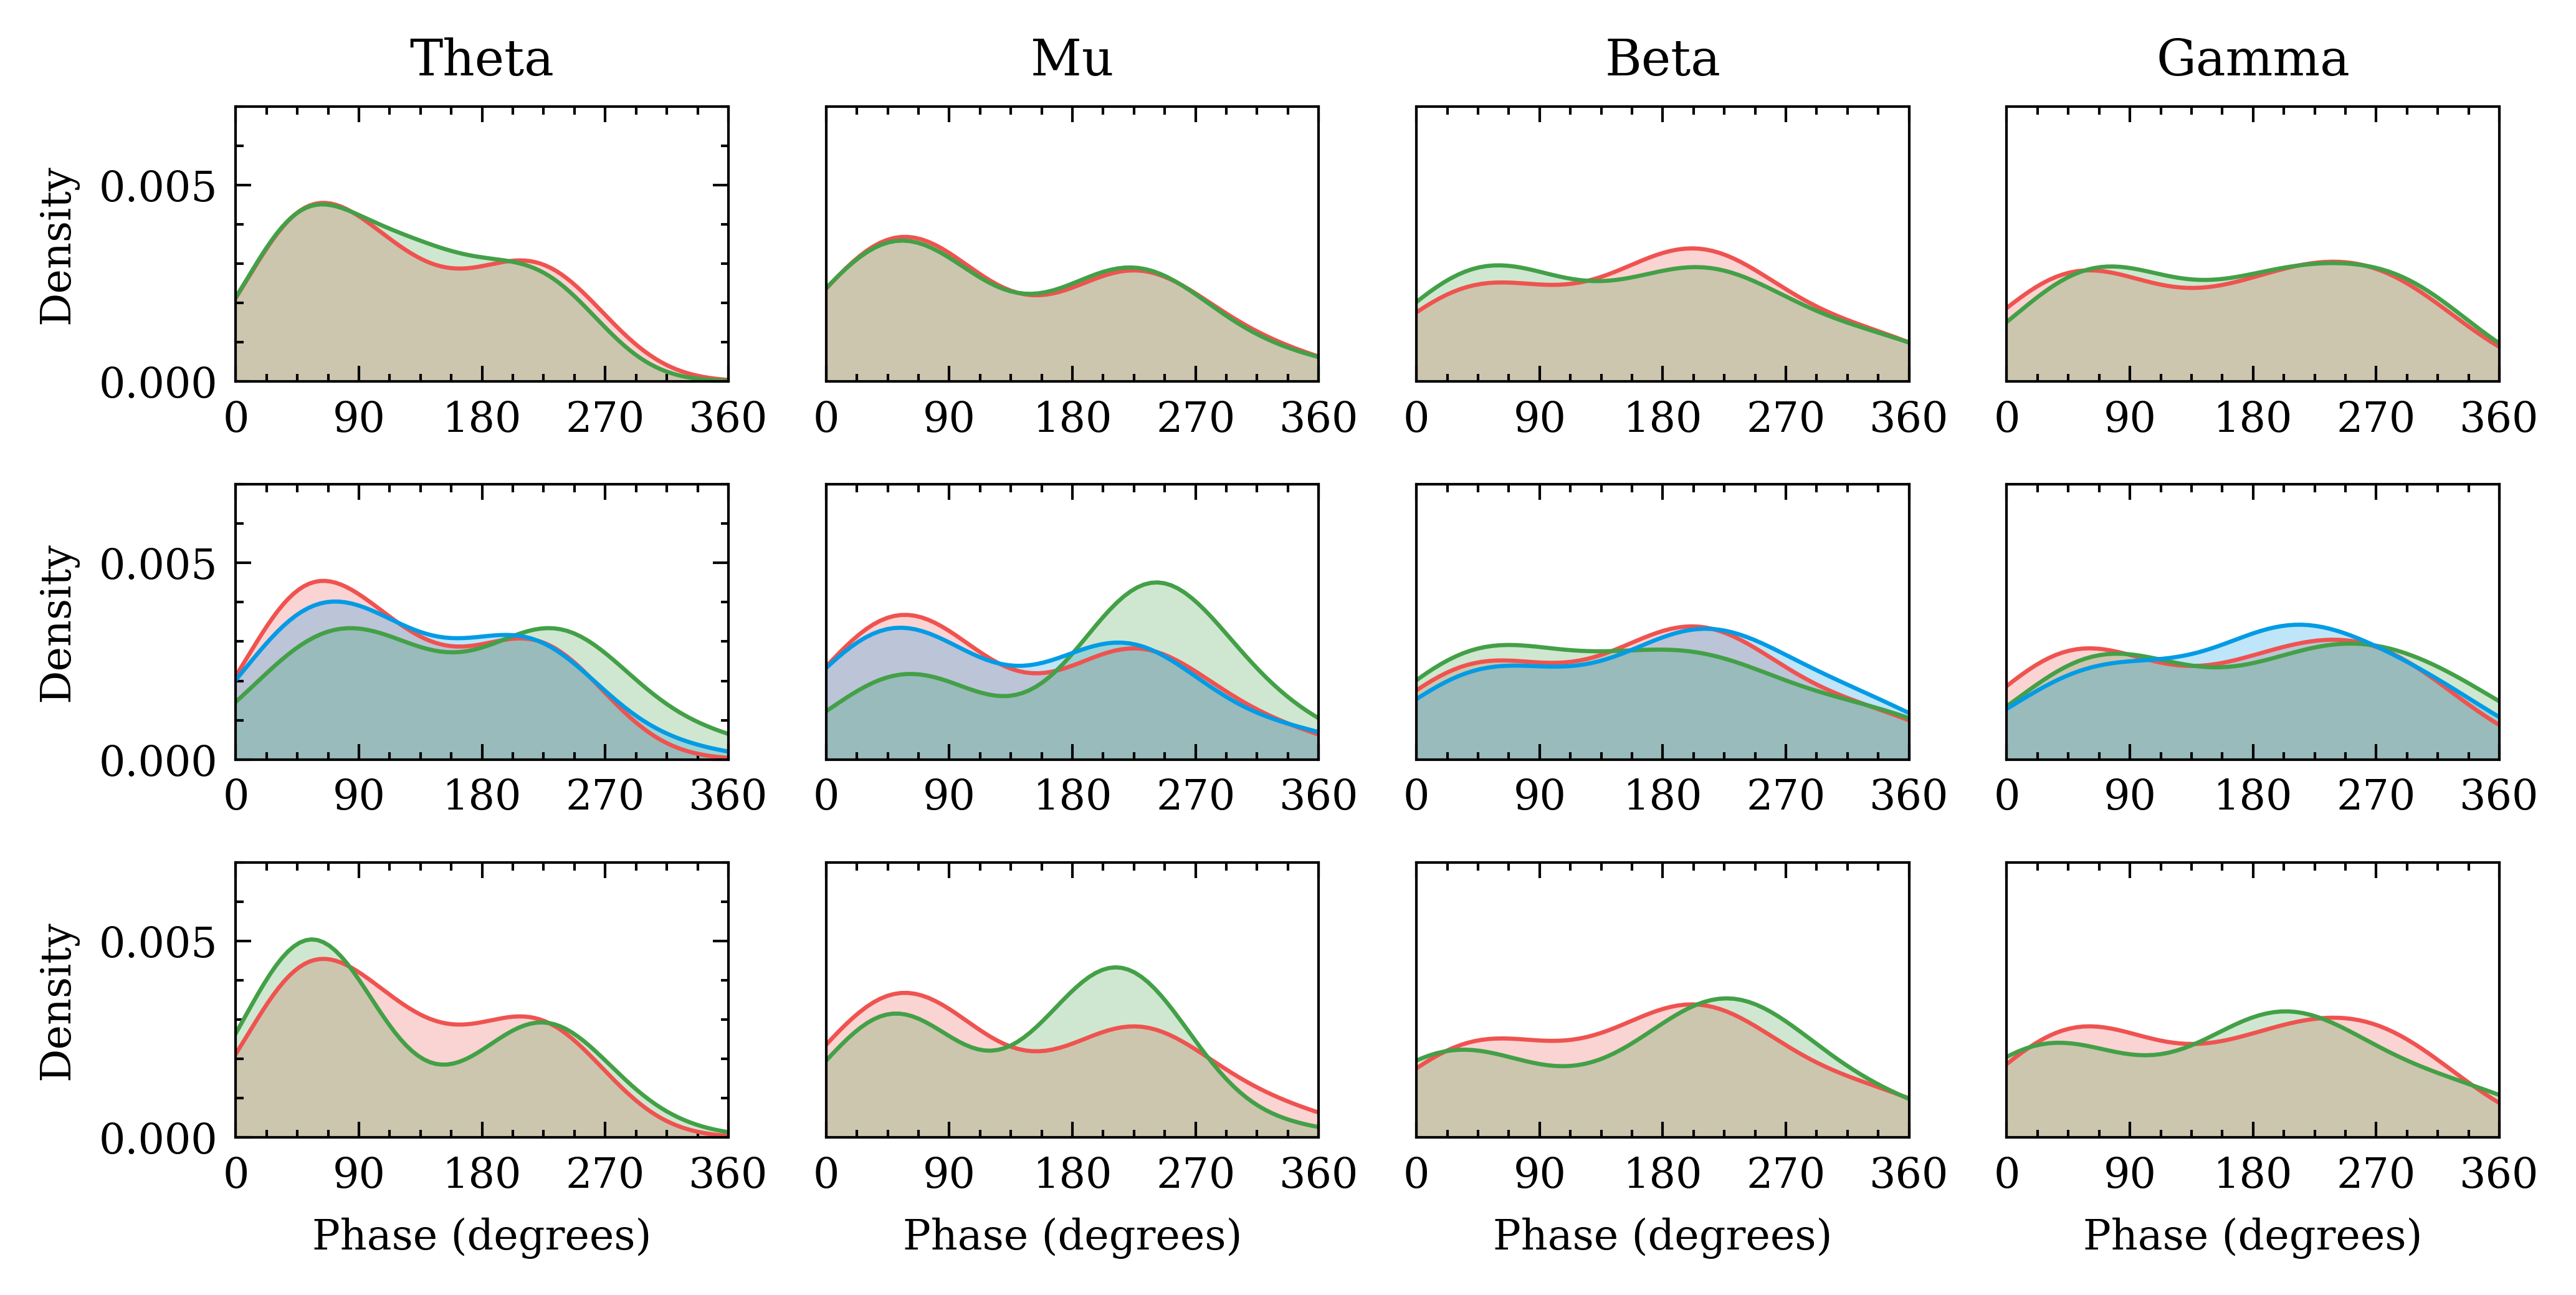

In [141]:
df_phase2 = df_phase[df_phase['sub'] == df_phase['sub'].unique()[10]]

with plt.style.context(['science-raquib']):
    colors = ['#EF5350', '#43A047', '#039BE5']
    f, axs = plt.subplots(3, 4, figsize=(7,3.5))
    i = 0
    j = 0
    color_ind = 0
    for variable in tqdm(list(def_values_phase.keys())):
        df_phase3 = df_phase2.copy()
        for key, value in def_values_phase.items():
                if key != variable:
                    df_phase3 = df_phase3[df_phase3[key] == value]
        for band in ['Theta', 'Mu', 'Beta', 'Gamma']:
            print('{}, Band: {}, Options: {}'.format(variable, band, df_phase3[variable].unique()))
            for option in df_phase3[variable].unique():
                df_phase4 = df_phase3[df_phase3['Band'] == band]
                df_phase4 = df_phase4[df_phase4[variable] == option]
                sns.distplot(df_phase4['Phase'], hist=False, color=colors[color_ind], kde_kws={"shade": True}, ax=axs[i, j])
                color_ind = color_ind + 1
                if i == 2:
                    axs[i, j].set_xlabel('Phase (degrees)')
                else:
                    axs[i, j].set_xlabel('')
                axs[i, j].set_xlim([0, 360])
                axs[i, j].set_ylim([0, 0.007])
                axs[i, j].set_xticks([0, 90, 180, 270, 360])
            if i == 0:
                axs[i, j].set_title(band)
            if j == 0:
                axs[i, j].set_ylabel('Density')
            else:
                axs[i, j].get_yaxis().set_visible(False)
            j = j + 1
            if j > 3:
                j = 0
            color_ind = 0
        i = i + 1
        
    plt.tight_layout()

# Correlation - power

In [150]:
print(df_power.shape)
df_power = df_power[~df_power['Power'].isin([np.nan, np.inf, -np.inf])]
print(df_power.shape)

(576288, 13)
(576000, 13)


In [151]:
df_corr = []
for sub in tqdm(df_power['sub'].unique()):
    df_sub = df_power[df_power['sub'] == sub]
    for key, val in def_values_power.items():
        df2 = df_sub
        for key2, val2 in def_values_power.items():
            if key != key2:
                df2 = df2[df2[key2] == val2]
        combs = list(combinations(sorted(df2[key].unique()), 2))
        for band in df_power['Band'].unique():
            df3 = df2[df2['Band'] == band]
            for value_pair in combs:
                data1 = df3[df3[key] == value_pair[0]]['Power'].values
                data2 = df3[df3[key] == value_pair[1]]['Power'].values
                mn = min(len(data1), len(data2))
                data1 = data1[0:mn]
                data2 = data2[0:mn]
                corr, _ = pearsonr(data1, data2)
                # print('sub: {}, band: {}, factor: {}, shape: [{}, {}]'.format(sub, band, key, data1.shape[0], data2.shape[0]))
                df_corr.append({
                    'subject': sub,
                    'band': band,
                    'factor': key,
                    'value_1': value_pair[0],
                    'value_2': value_pair[1],
                    'Correlation': corr
                })

In [152]:
df_corr = pd.DataFrame(df_corr)
df_corr['factor_value'] = df_corr.apply(lambda x: '{}: {} vs {}'.format(x['factor'], x['value_1'], x['value_2']), axis=1)
df_corr.head()

,Correlation,band,factor,subject,value_1,value_2,factor_value
0,0.935775,Theta,Artifact Removed,co2c0000337,No,Yes,Artifact Removed: No vs Yes
1,0.987275,Mu,Artifact Removed,co2c0000337,No,Yes,Artifact Removed: No vs Yes
2,0.964418,Beta,Artifact Removed,co2c0000337,No,Yes,Artifact Removed: No vs Yes
3,0.781788,Gamma,Artifact Removed,co2c0000337,No,Yes,Artifact Removed: No vs Yes
4,-0.033952,Theta,EEG,co2c0000337,Hjorth,M1 Average,EEG: Hjorth vs M1 Average


In [91]:
xlim = [-0.35, 1]

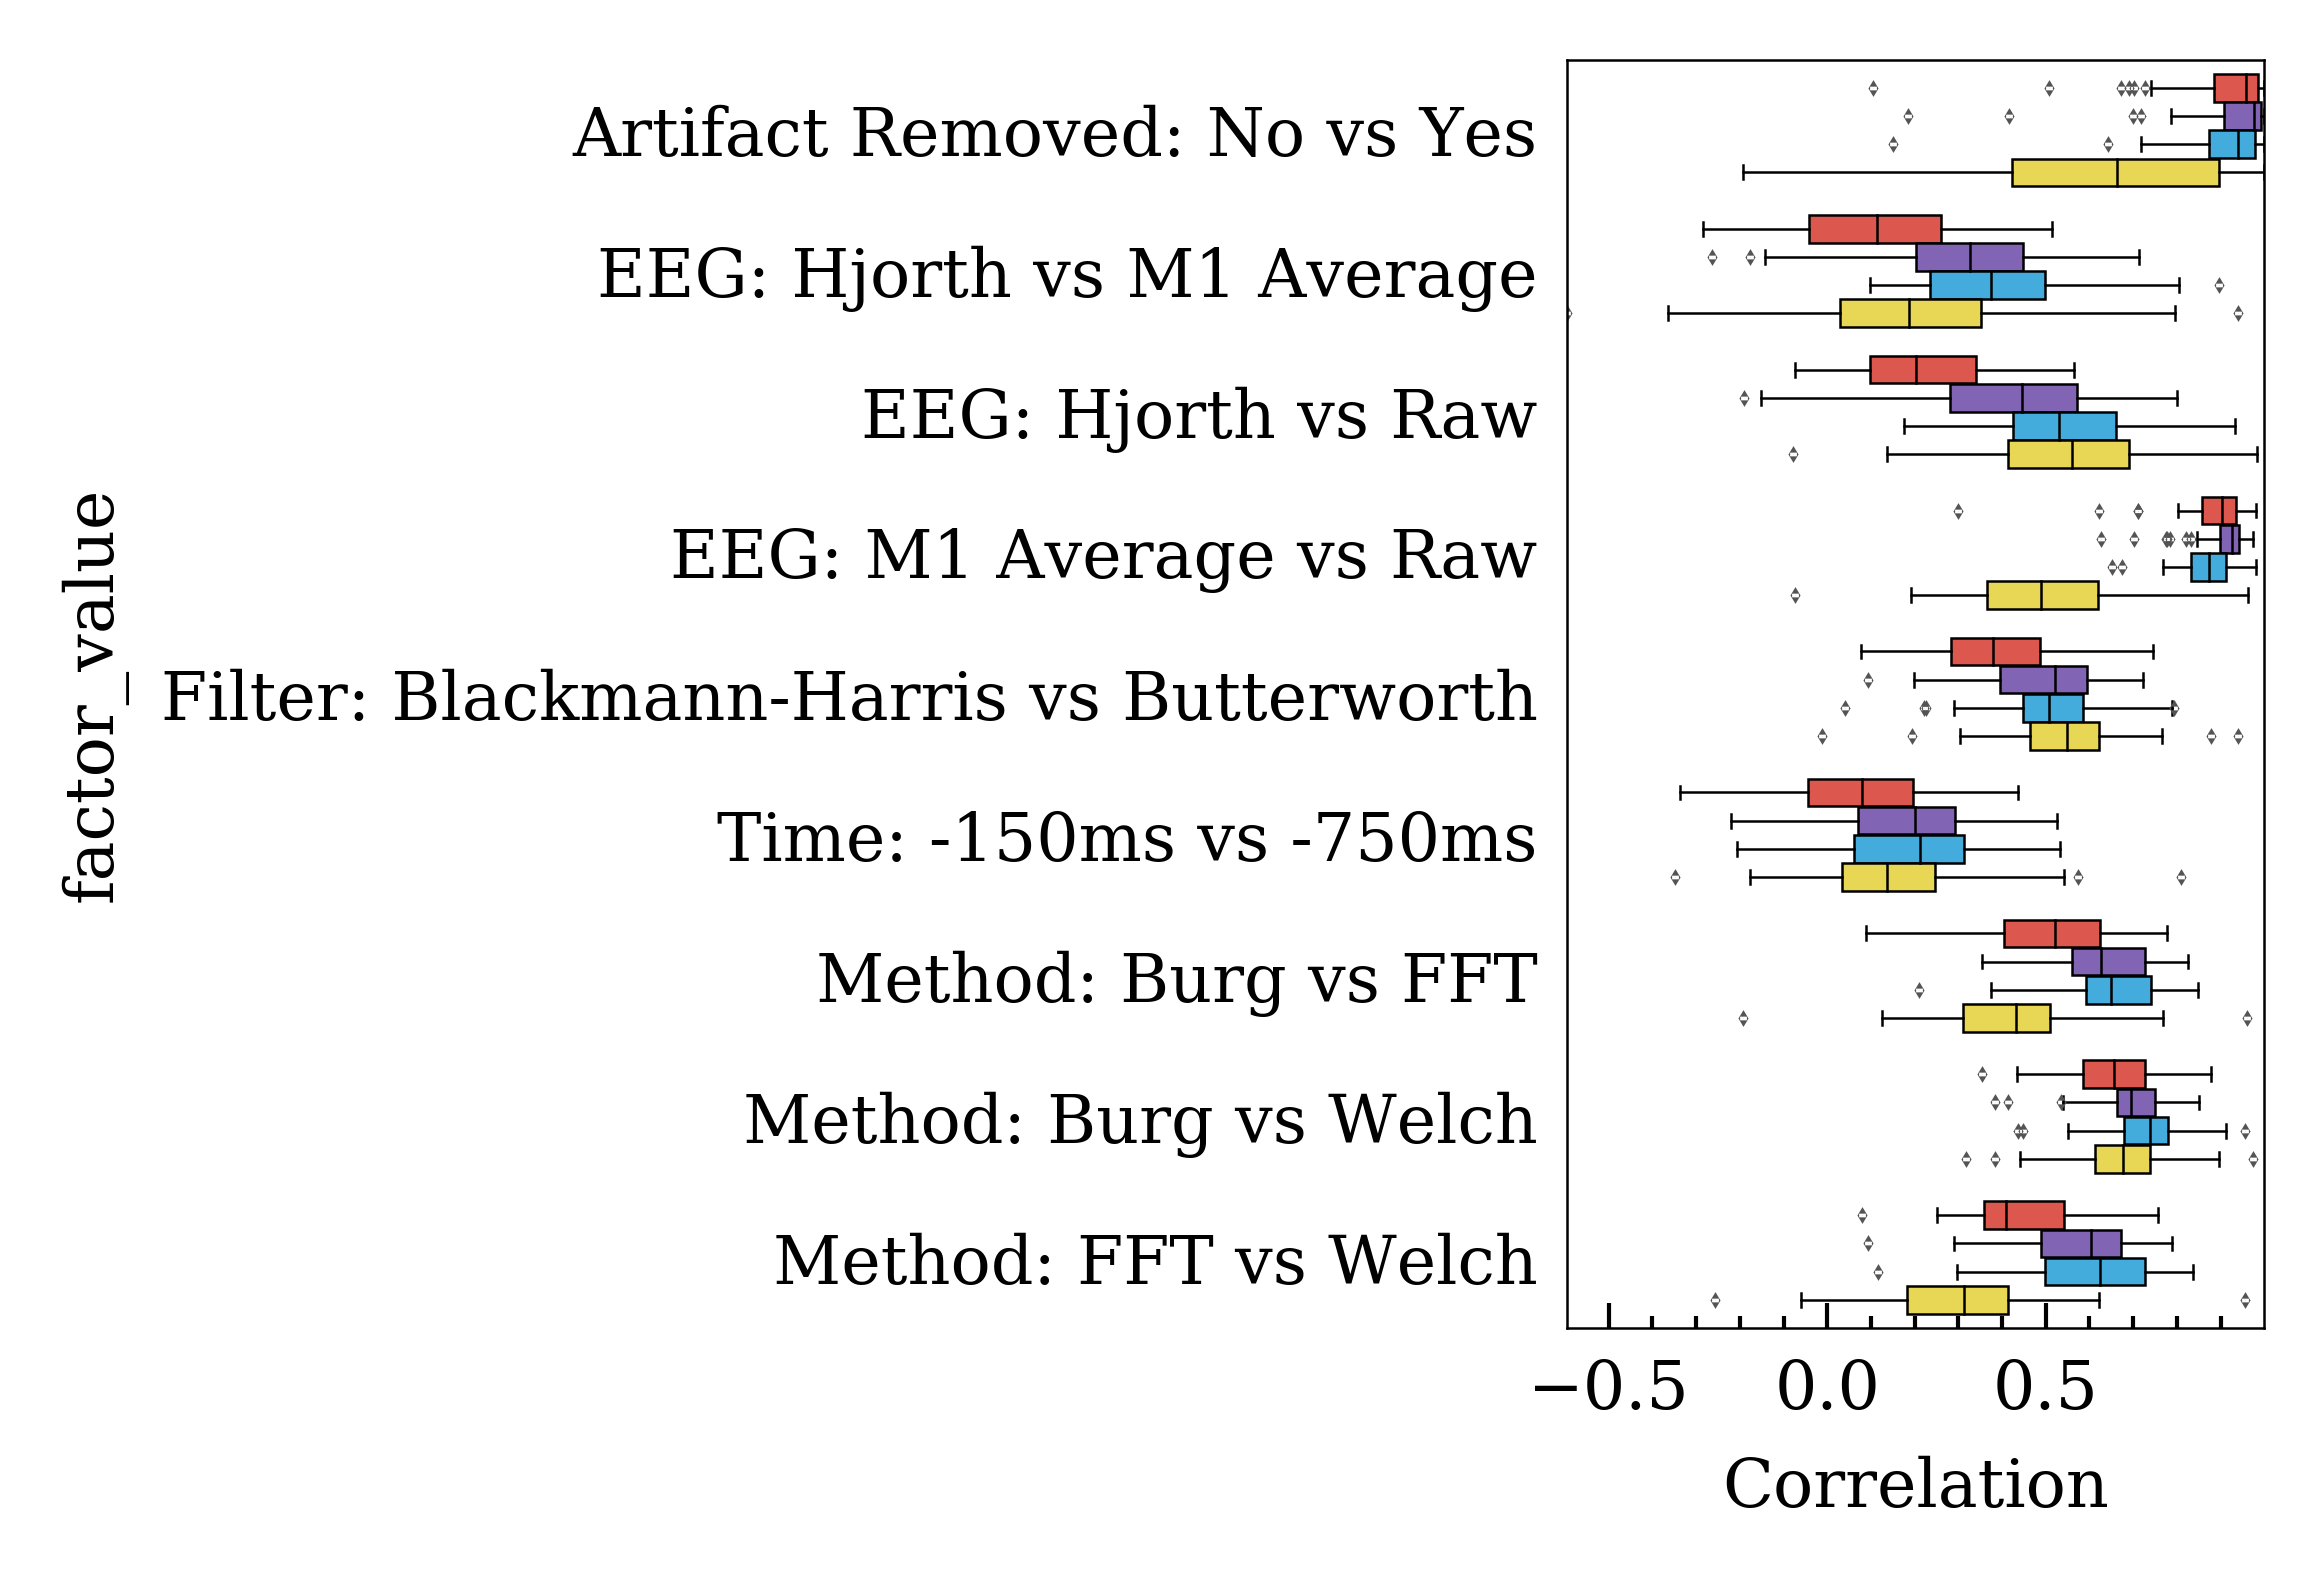

In [153]:
with plt.style.context(['science-raquib']):
    colors = ['#f44336', '#7e57c2', '#29b6f6', '#ffeb3b']
    fig, ax = plt.subplots(figsize=(1.5,2.8))
    g = sns.boxplot(y='factor_value', x='Correlation', hue='band', data=df_corr, orient='h', ax=ax, fliersize=0.05, linewidth=0.3, palette=[mcolors.to_rgba(c) for c in colors])
    ax.tick_params(axis='y', which='both', length=0)
#     ax.set_xlim(xlim)
    ax.get_legend().remove()
    plt.setp(ax.lines, color='k')
    for pos in ['top','bottom','left','right']:
        ax.spines[pos].set_linewidth(0.3)
    for i, box in enumerate(g.artists):
        box.set_edgecolor('black')
    ax.xaxis.set_ticks_position('bottom')

# Correlation - phase

In [154]:
df_phase_peak = df_phase[df_phase['Phase'] < 180]
df_phase_trough = df_phase[df_phase['Phase'] >= 180]

In [155]:
df_corr = []
for grp_name, df_phase_grp in zip(['peak', 'trough'], [df_phase_peak, df_phase_trough]):
    for sub in tqdm(df_phase_grp['sub'].unique()):
        df_sub = df_phase_grp[df_phase_grp['sub'] == sub]
        for key, val in def_values_phase.items():
            df2 = df_sub
            for key2, val2 in def_values_phase.items():
                if key != key2:
                    df2 = df2[df2[key2] == val2]
            combs = list(combinations(sorted(df2[key].unique()), 2))
            for band in df_phase['Band'].unique():
                df3 = df2[df2['Band'] == band]
                for value_pair in combs:
                    data1 = df3[df3[key] == value_pair[0]]['Phase'].values
                    data2 = df3[df3[key] == value_pair[1]]['Phase'].values
                    mn = np.min([data1.shape[0], data2.shape[0]])
                    data1 = data1[0:mn]
                    data2 = data2[0:mn]
                    corr, _ = pearsonr(data1, data2)
                    # print('sub: {}, band: {}, factor: {}, shape: [{}, {}]'.format(sub, band, key, data1.shape[0], data2.shape[0]))
                    df_corr.append({
                        'subject': sub,
                        'band': band,
                        'group': grp_name,
                        'factor': key,
                        'value_1': value_pair[0],
                        'value_2': value_pair[1],
                        'Correlation': corr
                    })

In [156]:
df_corr = pd.DataFrame(df_corr)
df_corr['factor_value'] = df_corr.apply(lambda x: '{}: {} vs {}'.format(x['factor'], x['value_1'], x['value_2']), axis=1)
df_corr.head()

,Correlation,band,factor,group,subject,value_1,value_2,factor_value
0,0.196034,Theta,Artifact Removed,peak,co2c0000337,No,Yes,Artifact Removed: No vs Yes
1,0.977279,Mu,Artifact Removed,peak,co2c0000337,No,Yes,Artifact Removed: No vs Yes
2,-0.045992,Beta,Artifact Removed,peak,co2c0000337,No,Yes,Artifact Removed: No vs Yes
3,0.200906,Gamma,Artifact Removed,peak,co2c0000337,No,Yes,Artifact Removed: No vs Yes
4,0.098952,Theta,EEG,peak,co2c0000337,Average,Hjorth,EEG: Average vs Hjorth


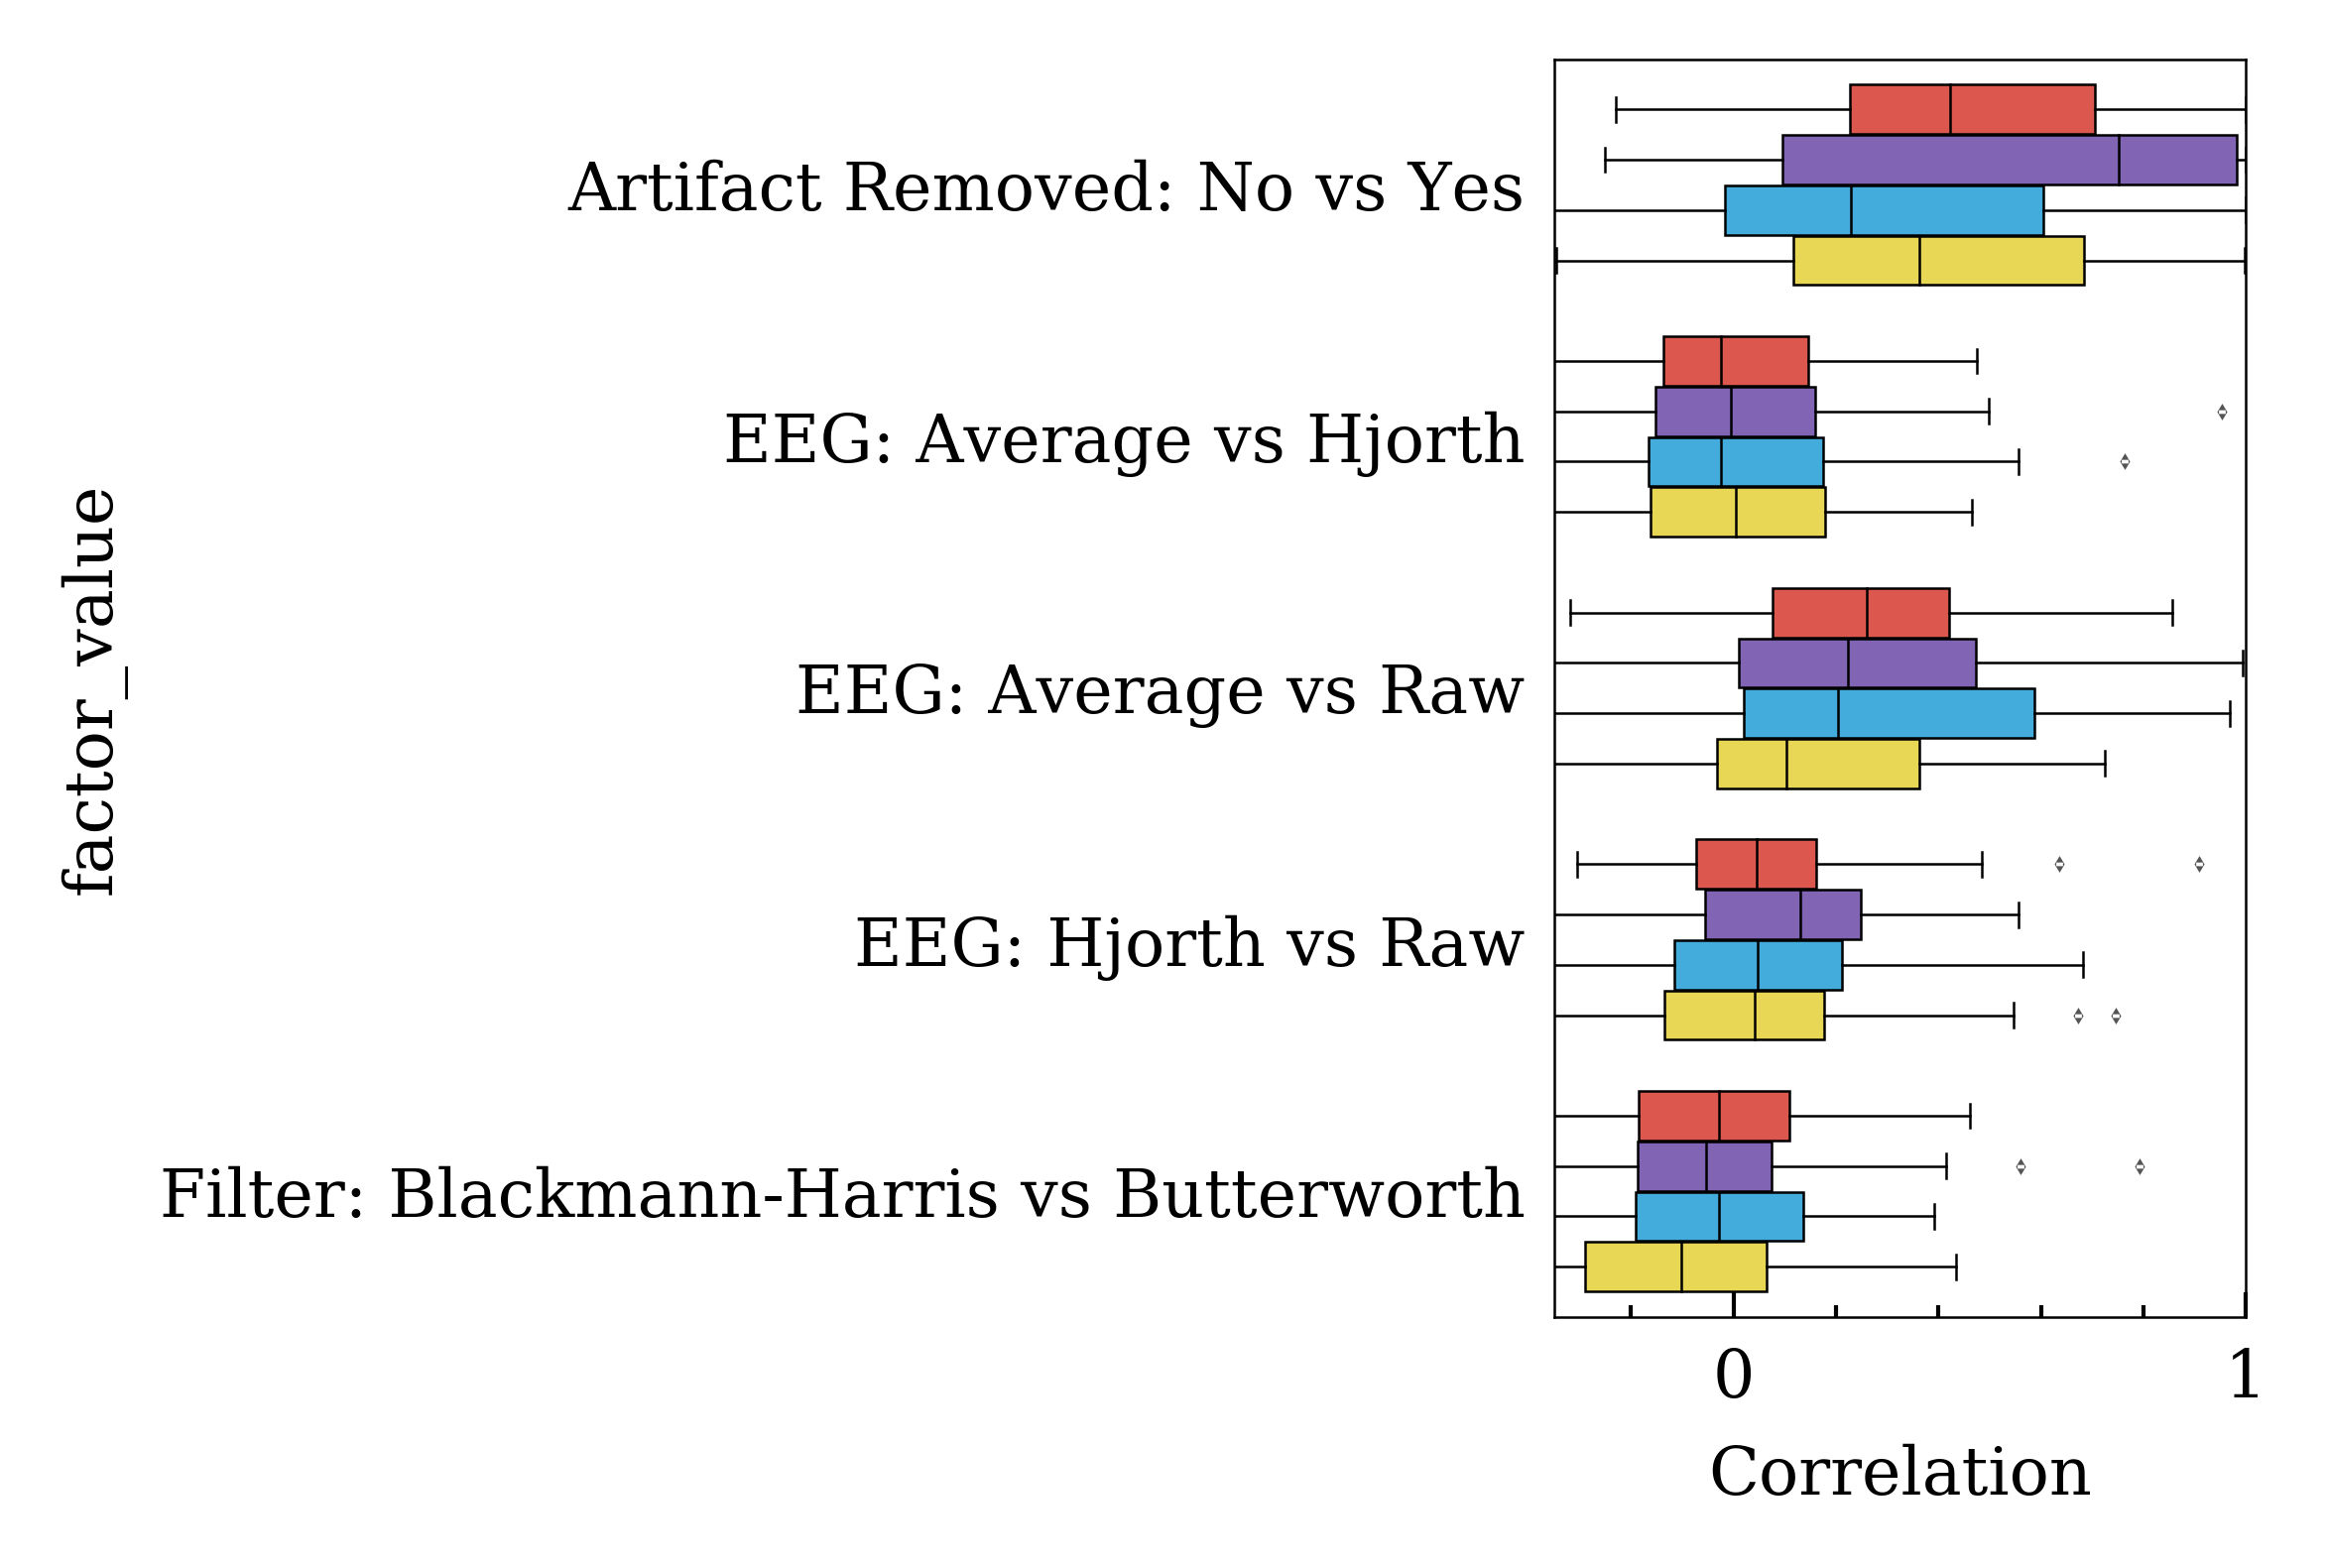

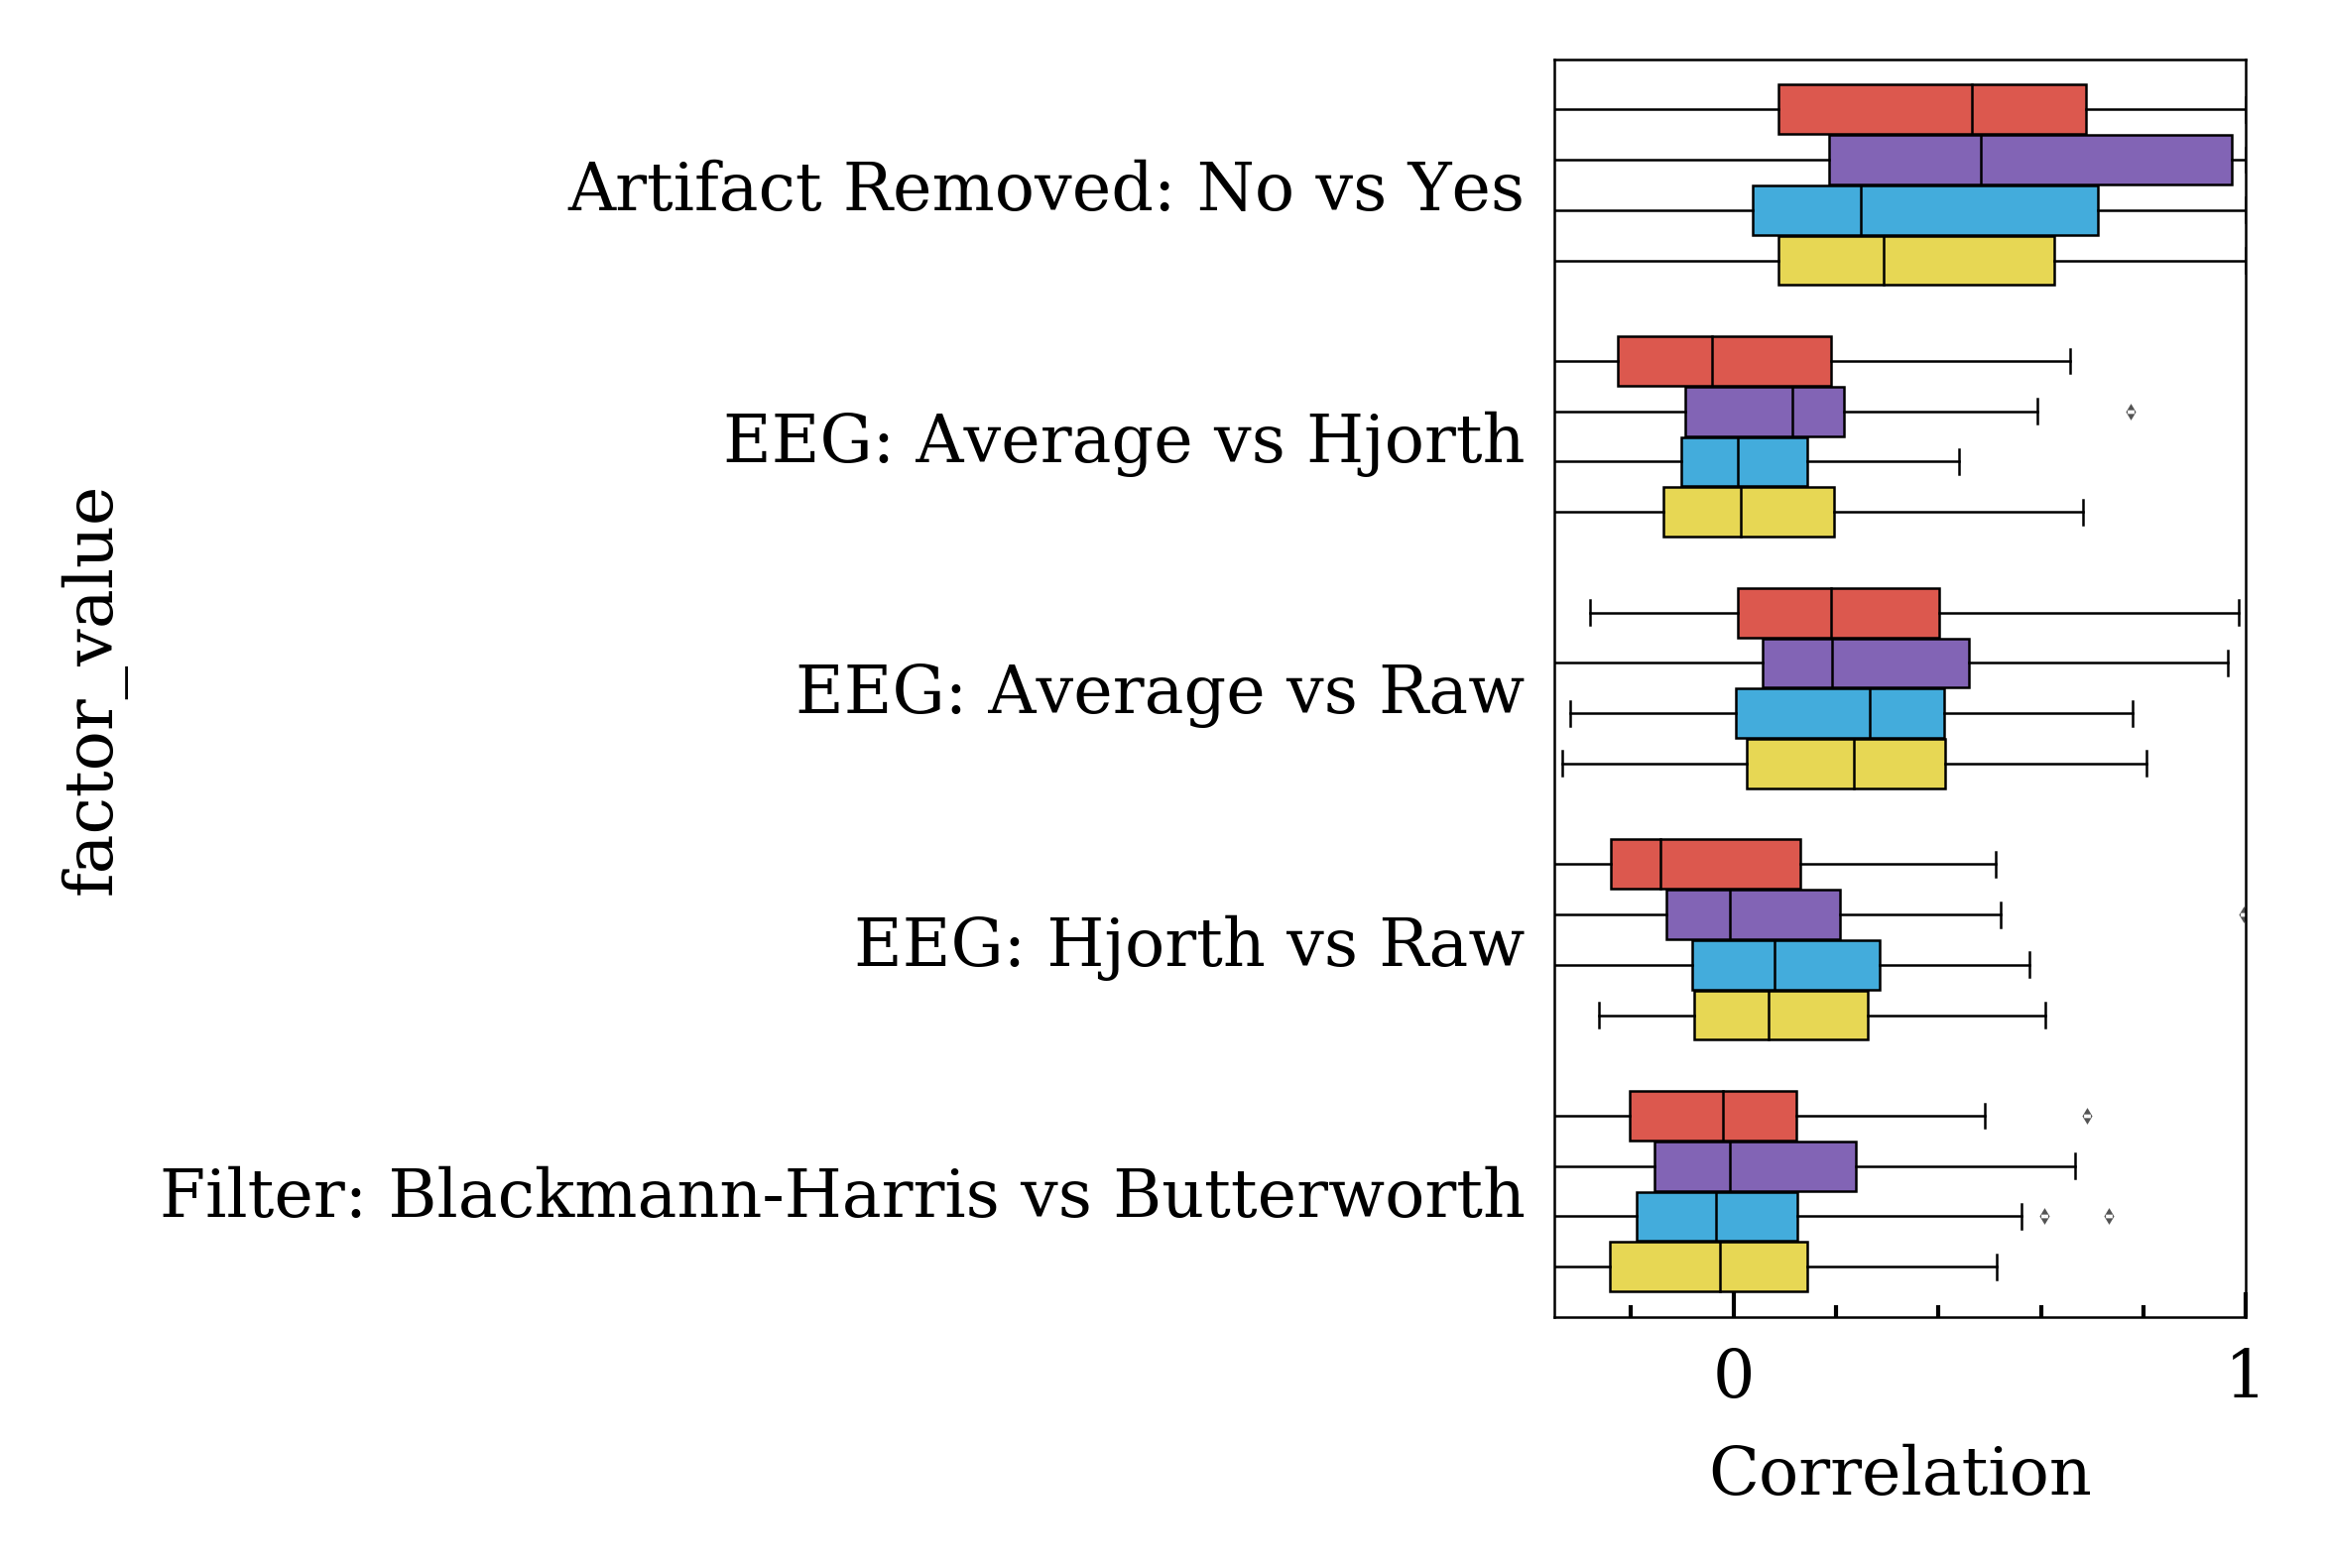

In [157]:
with plt.style.context(['science-raquib']):
    for grp in ['peak', 'trough']:
        df_corr2 = df_corr[df_corr['group'] == grp]
        colors = ['#f44336', '#7e57c2', '#29b6f6', '#ffeb3b']
        fig, ax = plt.subplots(figsize=(1.5,2.8))
        g = sns.boxplot(y='factor_value', x='Correlation', hue='band', data=df_corr2, orient='h', ax=ax, fliersize=0.05, linewidth=0.3, palette=[mcolors.to_rgba(c) for c in colors])
        ax.tick_params(axis='y', which='both', length=0)
        ax.set_xlim(xlim)
        ax.get_legend().remove()
        plt.setp(ax.lines, color='k')
        for pos in ['top','bottom','left','right']:
            ax.spines[pos].set_linewidth(0.3)
        for i, box in enumerate(g.artists):
            box.set_edgecolor('black')
        ax.xaxis.set_ticks_position('bottom')